## Testing the Solar Panel Simulation packages

---

### Dependencies
* `bms` -- a package to battery management system
* `nav` -- the "navigation" package, which in the current implementation is mostly a wrapper for `luseepy` objects

### Calculations vs cache

Calculating the path of the sun for extended periods of time can take a while, so
there are helper scripts that can do that once and save these data to disk, which
can be read quickly.

### Basic validation

...moved to _lusee-test_.





In [9]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Basic toolkit dependencies:
import  numpy as np
import  matplotlib.pyplot as plt

# Local imports
# Local power-related packages:
import bms
import nav # Includes the Sun class

from bms import *
from nav import *

print(f'''BMS package bersion:  {bms.__version__}''')
print(f'''NAV package bersion:  {nav.__version__}''')
print(f'''Name reported by the Panel class: {Panel.name}''')
print(f'''Panel PV efficiency at 0C: {Panel.pvEfficiency(0.0)}''')


BMS package bersion:  0.1
NAV package bersion:  0.1
Name reported by the Panel class: Base Panel Class.
Panel PV efficiency at 0C: 0.312152988744667


In [10]:
###############################################################################
# Read the prefab data on sun trajectory
import os
print('Current directory:', os.getcwd())
mySun = Sun()

cachefile = '../data/2025-02-04_03-07.npy'
mySun.read(cachefile)
print(f'''Number of points read from the file {cachefile}: {mySun.N}''')


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Loaded data from file "../data/2025-02-04_03-07.npy", number of points for the three components: 8979
Number of points read from the file ../data/2025-02-04_03-07.npy: 2993


## In the code below, it is assumed that the "Sun" object already exists and contains proper data

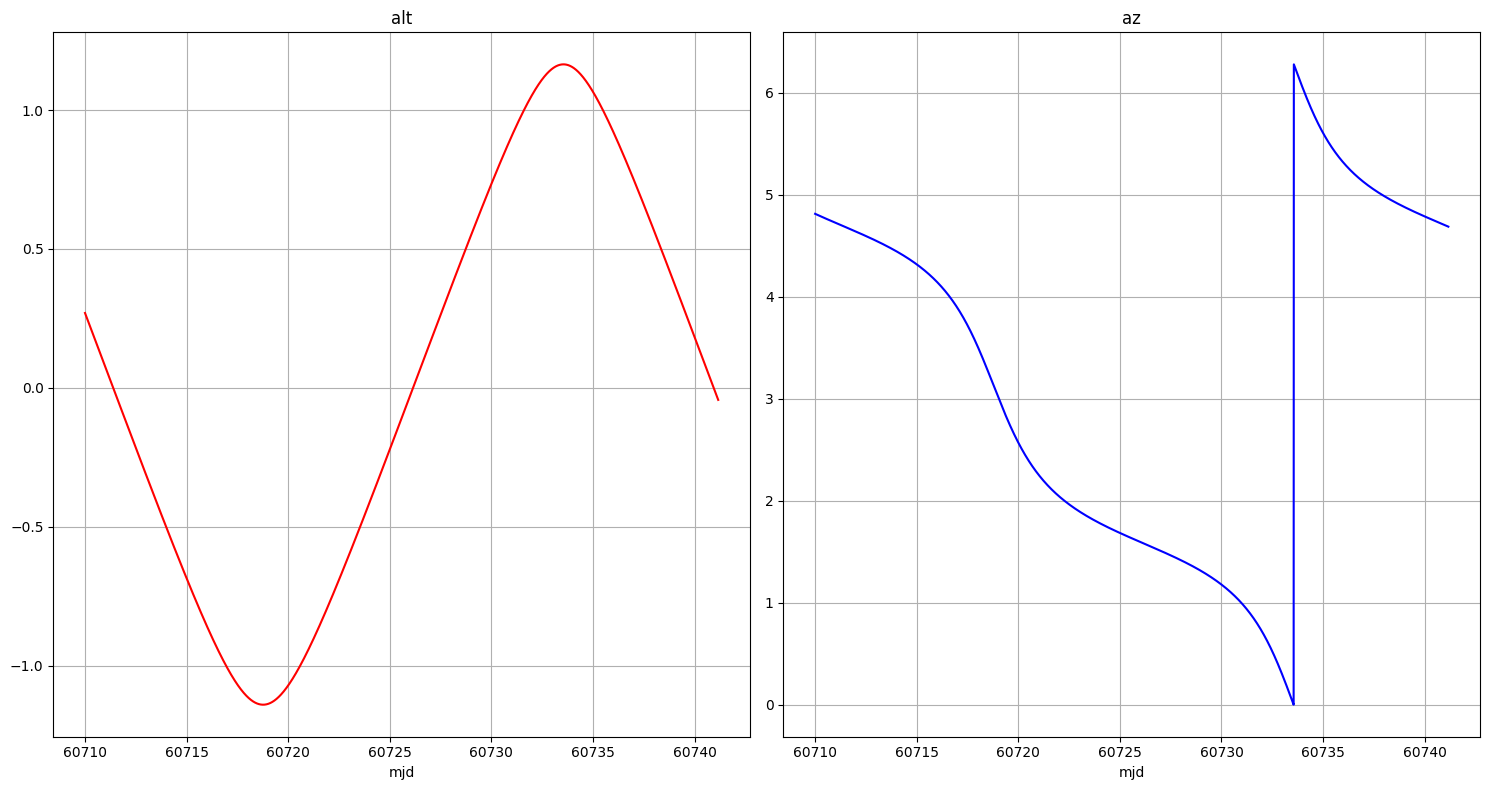

In [14]:
# Using the "mySun" object created above
fig, (p1, p2) = plt.subplots(1,2)

plt.rcParams["figure.figsize"] = [15., 8.]
plt.rcParams["figure.autolayout"] = True

p1.set_title("alt")
p1.plot(mySun.mjd, mySun.alt, color="red")
p1.grid(True)
p1.set_xlabel('mjd')

y = np.array(mySun.az)
p2.set_title("az")
p2.plot(mySun.mjd, mySun. az, color="blue")
p2.grid(True)
p2.set_xlabel('mjd')
plt.show()

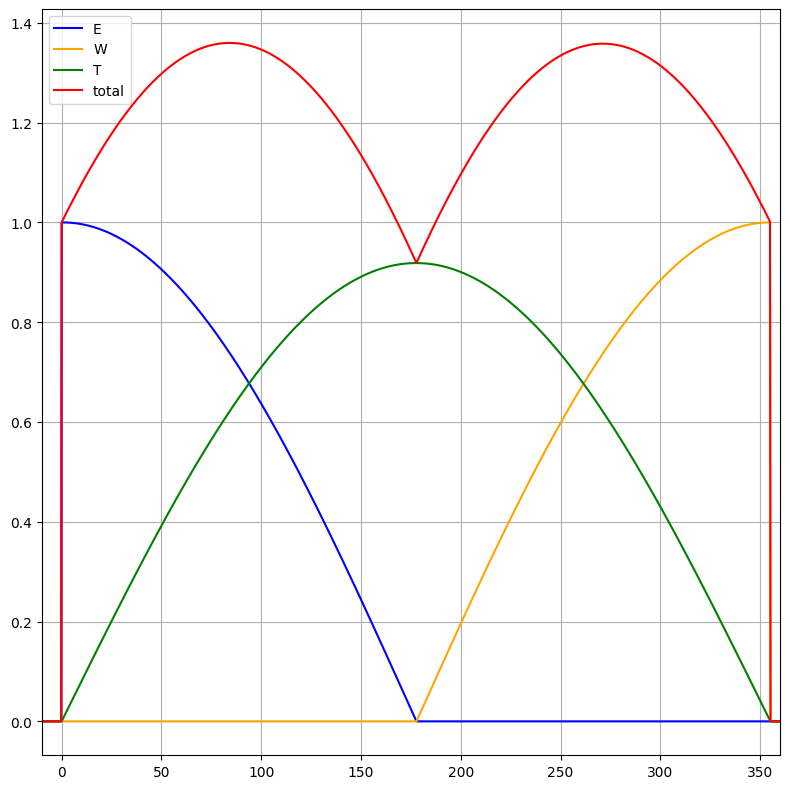

In [15]:
from bms.parts import Battery, Controller

battery = Battery() # a dummy battery here, just to create the controller
ctr     = Controller(battery)

alt_sun_top = mySun.alt_top #  np.asarray(mySun.alt)+sun_rad

sun     = mySun.xyz # altaz2xyz(mySun.alt, mySun.az)
sun_top = altaz2xyz(alt_sun_top, mySun.az)

e = EPanel(sun, 'E')
ctr.add_panel(e)

w = WPanel(sun, 'W')
ctr.add_panel(w)

t = TPanel(sun, 'T')
ctr.add_panel(t)

# ---------------------------------------------------------
ctr.set_condition(mySun.condition)

hrs = mySun.hrsFromSunrise()

ePower, wPower, tPower = e.power(), w.power(), t.power()
#wPower = w.power()
#tPower = t.power()

totalPower = ctr.panels_power()

plt.rcParams["figure.figsize"] = [8., 8.]
plt.rcParams["figure.autolayout"] = True
plt.plot(hrs,   ePower,     color="blue",   label="E")
plt.plot(hrs,   wPower,     color="orange", label="W")
plt.plot(hrs,   tPower,     color="green",  label="T") 
plt.plot(hrs,   totalPower, color="red",    label="total")
plt.xlim(-10, 360)
plt.grid(True)
plt.legend()

# print(hrs.size, totalPower.size)
# print(hrs[2970:], totalPower[2970:])


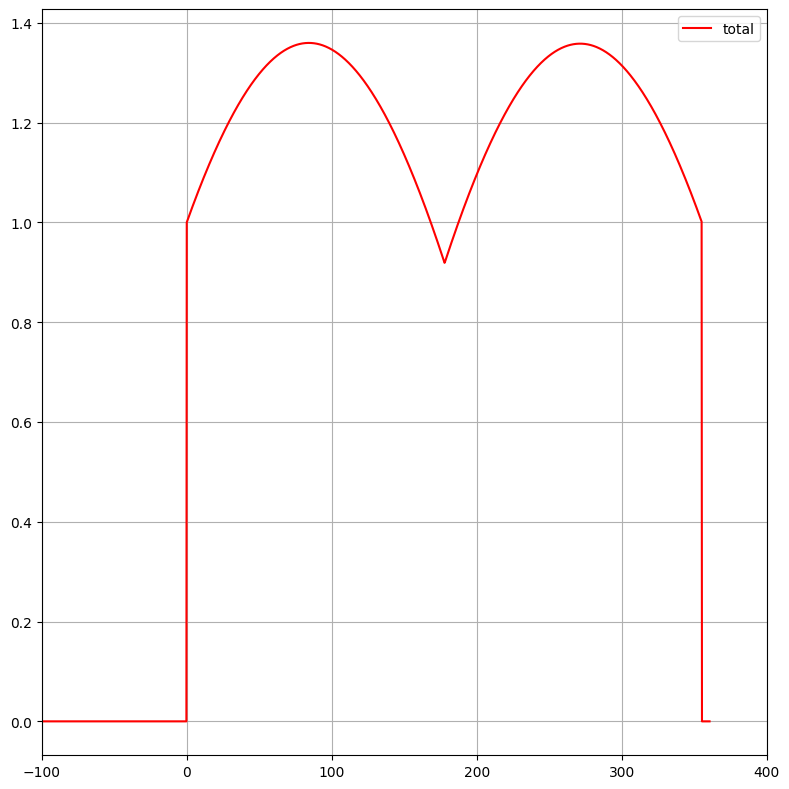

In [16]:
# Shorter example demonsrtating wrappers
# We assume that nav parameters -- alt, z, on mjd points -- have been calculated above...

from bms.parts          import Battery, Controller
from nav.coordinates    import *

# Let's assume the sun was initialized in the cells above
# mySun = Sun(mjd, alt, az)

battery = Battery(0.0) # Dummy battery, just to satisfy the controller
ctr     = Controller(battery)
ctr.add_all_panels(sun)
ctr.set_condition(mySun.condition)
hrs = mySun.hrsFromSunrise() # hrsFromSunrise(alt, mjd)

plt.plot(hrs, ctr.panels_power(), color="red",    label="total")
plt.xlim(-100,400)
plt.grid(True)
plt.legend()


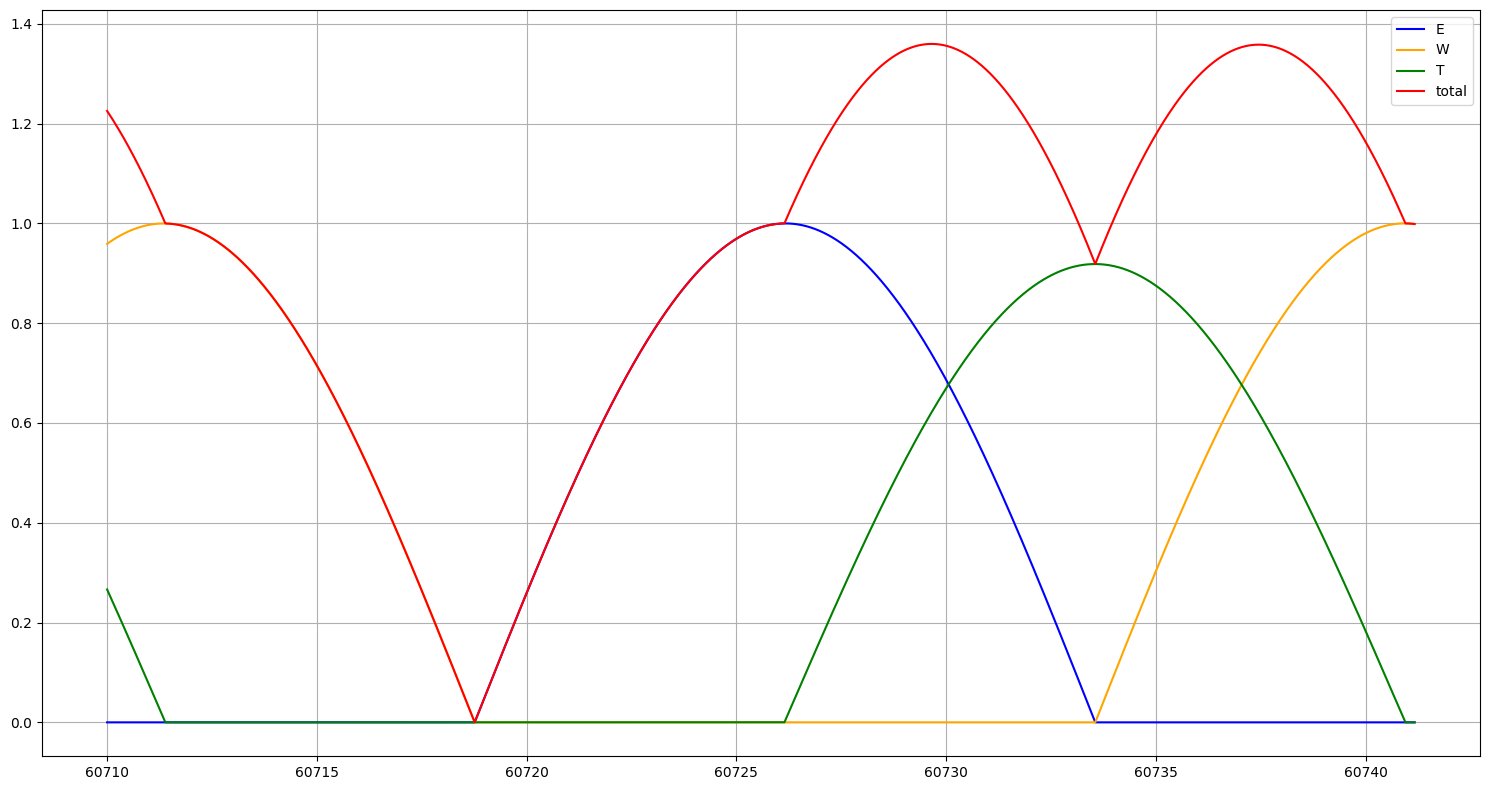

In [26]:
############################################ OPTIONAL: Panel power plot w/o the conditions ###############

t_dot_sun_top = t.dot(sun_top)
# For finite disk at sunrise/sunset. Slight aprx: top of sun not center of segment
t_dot_sun_top[t_dot_sun_top < 0] = 0.0


plt.rcParams["figure.figsize"]      = [15., 8.]
plt.rcParams["figure.autolayout"]   = True

plt.plot(mySun.mjd, e.dot_sun, color="blue",  label="E")
plt.plot(mySun.mjd, w.dot_sun, color="orange",label="W")
plt.plot(mySun.mjd, t.dot_sun, color="green", label="T")

tot = e.dot_sun + w.dot_sun + t.dot_sun

plt.plot(mySun.mjd, tot, color="red",    label="total")

plt.grid(True)
plt.legend()
plt.show()

# Sanitize input to arccos and sqrt. Values where h<0 are non-physical and will be cut by condition_list.
# alt_seg = np.abs(alt)
# alt_seg[alt_seg>sun_rad]=sun_rad
# sun_seg_area = (sun_rad**2)*np.arccos(1-((sun_rad-alt_seg)/sun_rad))-alt_seg*np.sqrt((sun_rad**2)-(alt_seg)**2)
# sun_seg_frac = sun_seg_area/(np.pi*sun_rad**2)